In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


## Functions

### General usable

#### Cleaning

In [72]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [73]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [74]:
def lowercase_underscore_column_names(this_df):
    """changes all columnnames to lower case and replace space with underscore"""
    for col in this_df.columns:
        this_df.rename(columns={col:col.lower().replace(" ", "_")}, inplace=True)

In [75]:
def all_numeric_to_int(this_df):
    for col in split_column_names_by(this_df)[0]:
        this_df[col] = this_df[col].astype(np.int64)

In [76]:
def remove_index_column(this_df):
    """checks and if apllicable removes "Unnamed: 0"-column which might be in file when csv saving was done with index"""
    if this_df.columns[0][:7] == "unnamed":
        this_df = this_df.drop(this_df.columns[0],axis=1,inplace=True)

In [77]:
def replace_nan_values_w_median(this_df):
    for col in split_column_names_by(this_df)[0]:
        if this_df[col].isna().sum() > 0:
            col.fillna(np.median(col))
    return this_df

#### Plotting

In [78]:
def count_plot_w_hue(this_df, this_x: [str] = None, this_hue: [str] = None, x_bins: [int] = 4, hue_bins: [int] = 4,
                     palette: [str] = "YlOrRd", figsize: [tuple] = (10, 8), legend_loc: [str] = "upper right",
                     rotate_xlabels: [int] = None, show_plot: [bool] = True, save_to: [str] = None):
    # __author__ = "Roman Kaltschew"
    """creates count_plot of this_x with optional this_hue of this_df, if either column is numerical, evenly spread 
       bins according value of x_bins or hue_bins will be created. Takes values for figsize, legend_loc and palette 
       according to seaborn library, save_to takes filepath and saves accordingly, provide rotate_xlabels if needed.
       Catches empty df, wrong values for this_x and this_hue with error message. 
       x_bins or hue_bins will be set to 1 if < 1."""

    if this_df is None:
        return "DataFrame is empty"

    # prepare data
    if x_bins < 1:
        x_bins = 1
    if hue_bins < 1:
        hue_bins = 1

    if this_x in split_column_names_by(this_df)[0]:     # this_x is numerical
        bin_limits = np.linspace(np.min(this_df[this_x]), np.max(this_df[this_x]), x_bins + 1)
        bin_labels = [f" ≤ {_}" for _ in np.round(bin_limits, 2)[1:len(bin_limits)]]
        x_ser = pd.cut(this_df[this_x], bins=bin_limits, labels=bin_labels)
    elif this_x in split_column_names_by(this_df)[1]:   # this_x is categorical
        x_ser = this_df[this_x].sort_values()
    else:
        return "check this_x value"

    if this_hue:    # evaluate only if provided
        if this_hue in split_column_names_by(this_df)[0]:  # this_y is numerical
            bin_limits = np.linspace(np.min(this_df[this_hue]), np.max(this_df[this_hue]), hue_bins + 1)
            bin_labels = [f" ≤ {_}" for _ in np.round(bin_limits, 2)[1:len(bin_limits)]]
            hue_ser = pd.cut(this_df[this_hue], bins=bin_limits, labels=bin_labels)
        elif this_hue in split_column_names_by(this_df)[1]:  # this_y is categorical
            hue_ser = this_df[this_hue].sort_values()
        else:
            return "check this_hue value"
        title_text = f"{this_x.capitalize().replace('_', ' ')} by {this_hue.capitalize().replace('_', ' ')}"
    else:                          # ↳ reformat column names, 1st letter uppercase and _ replaced by space                           
        hue_ser = None  
        title_text = f"{this_x.capitalize().replace('_', ' ')}"
    
    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.countplot(x=x_ser, y=None, hue=hue_ser, palette=palette)
    ax.set_title(title_text, size="18", fontweight="bold")  
    ax.set_xlabel(f"{this_x.capitalize().replace('_', ' ')}")   # reformat column name
    if rotate_xlabels:     # avoid overlapping
        plt.xticks(rotation=rotate_xlabels)
    if this_hue:      # legend is only needed, if hue was given
        plt.legend(loc=legend_loc)
    if save_to:
        plt.savefig(save_to)
    if show_plot:
        plt.show()

### Project Specific

#### Cleaning

In [9]:
def extract_month(value):
    """for string from date in format MM/DD/YYYY"""
    return value.split("/")[0]

In [10]:
def gender_generalize(gender:[str], replace_nan:[str] = "---"):
    """changes the genders to female if f in str, else male. if gender = nan replace_nan_with ("---" default) is returned"""
    if type(gender) != str:
        return replace_nan
    if "f" in gender.lower():
        return "female"
    else:
        return "male"

In [11]:
def distrib_plots(num_df):
    """creates plot for every column, checks column is numerical and automatically adjusts the grid matrix"""
    matrix_size = math.ceil(len(num_df)**0.5)
    plt.figure(figsize = (14,12))
    for i, col in enumerate(num_df.columns, 1):
        if is_numeric_dtype(num_df[col]):
            plt.subplot(3,3,i)
            sns.distplot(num_df[col], kde=True)

In [12]:
def st_to_state(this_df):
    """PROJECT SPECIFIC: checks, if there is a column named ST and changes it to state"""
    if "ST" in list(this_df.columns) or "State" in list(this_df.columns):
        this_df.rename(columns={"ST":"state", "State":"state"}, inplace=True)
    return this_df

In [13]:
def correct_open_complaints(value):
    """PROJECT SPECIFIC: the number of open complaints has in some cases the structure 1/0/00, where only the middle 
       number is interesting. if value has this format, only the middle value is returned as int"""
    if "/" in str(value):
        return int(value.split("/")[1])
    else:
        return int(value)

In [14]:
def clean_cust_lifetime_value(value):
    """PROJECT SPECIFIC: takes a value and checks, whether a % sign is in it, in that case returns value 
       divided by 100 with % sign removed """
    if str(value) == "NaN":
        return None
    if "%" in str(value):
        return float(value.replace("%",""))/100
    else:
        return float(value)

In [15]:
#source: https://www.50states.com/abbreviations.htm
def states_to_zones_flex(state:[str]):
    """PROJECT SPECIFIC: takes state in str format and returns zone according to zones_dict"""
    # add / change as required
    zones_dict = {
        "east": ["wa", "washington"],
        "central": ["nevada", "arizona", "nv", "az"],
        "west": ["california", "cali", "ca"],
        "northwest": ["oregon", "oreg", "or"],
    }
    state = state.lower()
    for zone in zones_dict.items():
        if state in zone[1]:
            return zone[0]
    return None

In [16]:
def all_columns_in_file1_to_3():
    """PROJECT SPECIFIC: sort and print all columns next to each other to see difference in the names.
       Print True or False if set(all_columns) == set(file1_df.columns)"""
    if file1_df is not None and file2_df is not None and file3_df is not None:
        all_columns = sorted(file1_df.columns) + sorted(file2_df.columns) + sorted(file3_df.columns)
        for _ in range(0,11):
            print(all_columns[_], all_columns[_+11], all_columns[_+22])
        print("\nThe length of the set(all_columns) is equal to length of columns in one df:",len(set(all_columns))==len(file1_df.columns))

#### Plotting

In [17]:
# TODO: implement grid system
def distribution_plots(num_df):
    for col in num_df.columns[1:]:
        sns.displot(num_df, x=col, kde=True)

In [18]:
def hist_plots(num_df):
    """creates plot for every column, checks column is numerical and automatically adjusts the grid matrix"""
    matrix_size = math.ceil(len(num_df)**0.5)   # create square matrix according to number of columns 
    plt.figure(figsize = (14,12))
    for i, col in enumerate(num_df.columns, 1):
        if is_numeric_dtype(num_df[col]):
            plt.subplot(3,3,i)
            sns.histplot(num_df[col], kde=True)


In [19]:
def heat_map(num_df):
    corr = num_df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(9, 7))
        ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Read & Clean - Data_Marketing_Customer_Analysis_Round2.csv

In [63]:
raw_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/Data_Marketing_Customer_Analysis_Round2.csv")

In [21]:
lowercase_underscore_column_names(raw_df)

In [22]:
remove_index_column(raw_df)

In [23]:
# extract the month of the effective_to_date column
raw_df["month"] = list(map(extract_month,(raw_df["effective_to_date"])))

In [24]:
# create df and select onyl the first quarter (month 1-3)
selected_df = raw_df.loc[np.int64(raw_df['month']) < 4]

In [25]:
# selected_df.describe()

In [26]:
# selected_df.info()

## EDA

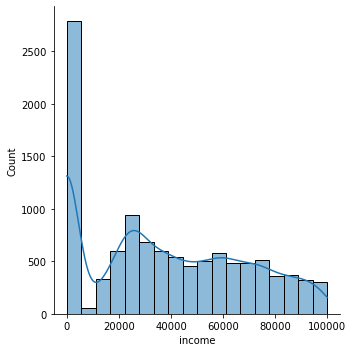

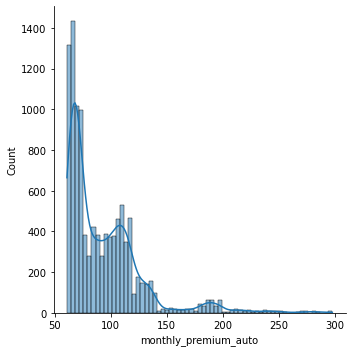

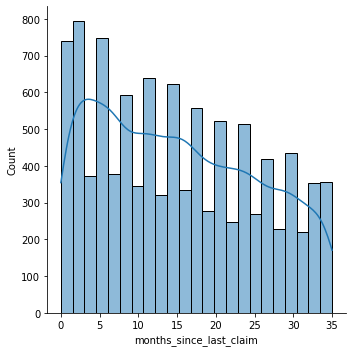

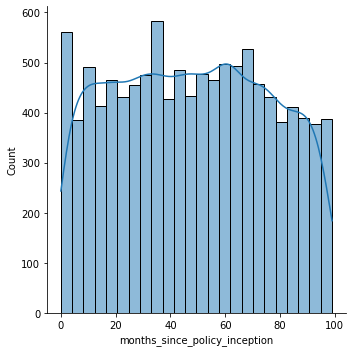

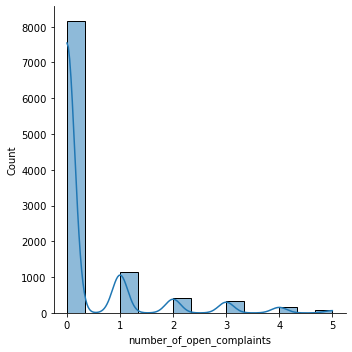

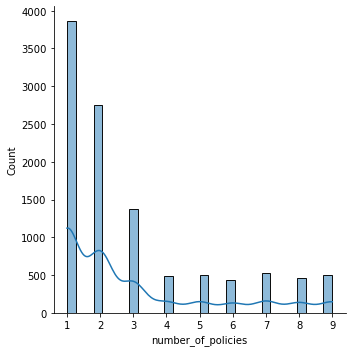

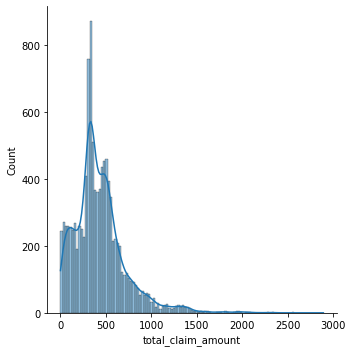

In [27]:
distribution_plots(split_df_by(raw_df)[0])

C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

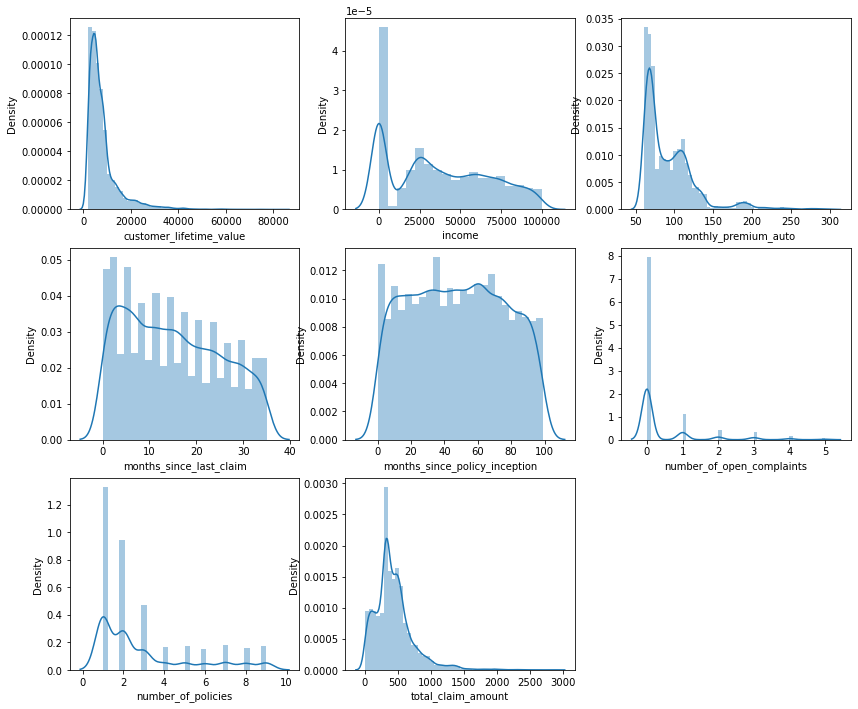

In [28]:
distrib_plots(split_df_by(raw_df)[0])

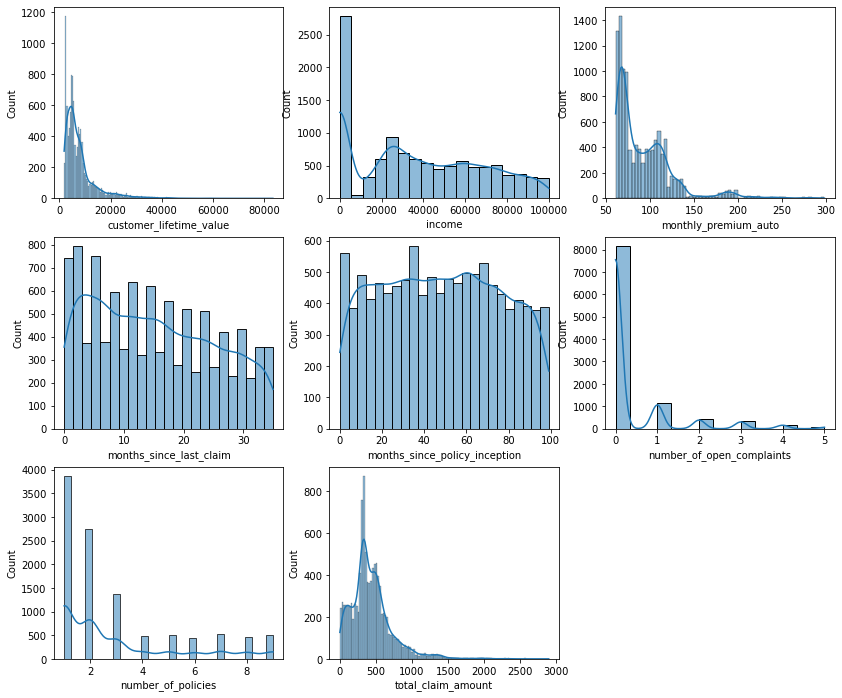

In [29]:
hist_plots(split_df_by(raw_df)[0])

What is to be done **about the 0 values** in income and clv?

***

** Total Response **

<AxesSubplot:xlabel='response', ylabel='count'>

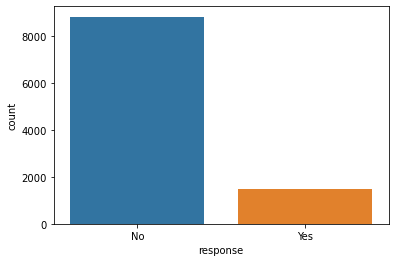

In [30]:
sns.countplot(x=raw_df["response"])

In [31]:
raw_df['response'].value_counts(normalize=True)

No     0.857379
Yes    0.142621
Name: response, dtype: float64

In [32]:
print(f"""The response rate was
    {round(raw_df['response'].value_counts(normalize=True)[0], 2)} % {raw_df['response'].value_counts(normalize=True).index[0]} and 
    {round(raw_df['response'].value_counts(normalize=True)[1], 2)} % {raw_df['response'].value_counts(normalize=True).index[1]}.""")      

The response rate was
    0.86 % No and 
    0.14 % Yes.


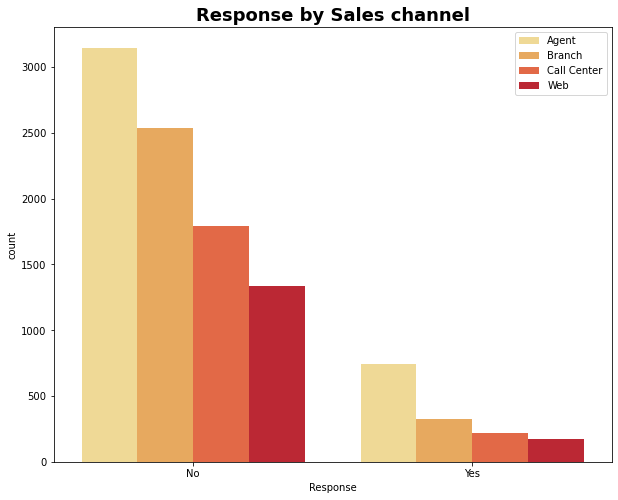

In [33]:
count_plot_w_hue(raw_df, "response", "sales_channel")

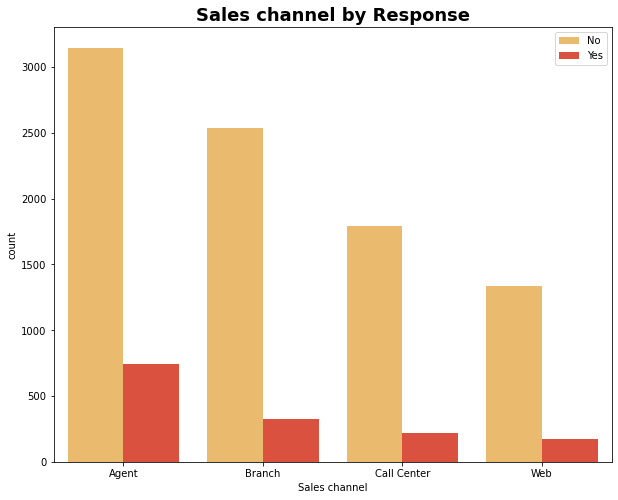

In [34]:
count_plot_w_hue(raw_df, "sales_channel", "response")

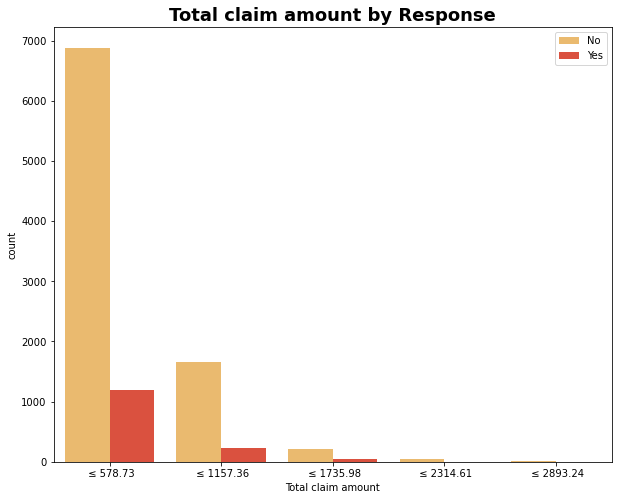

In [35]:
count_plot_w_hue(raw_df, "total_claim_amount", "response", x_bins=5)

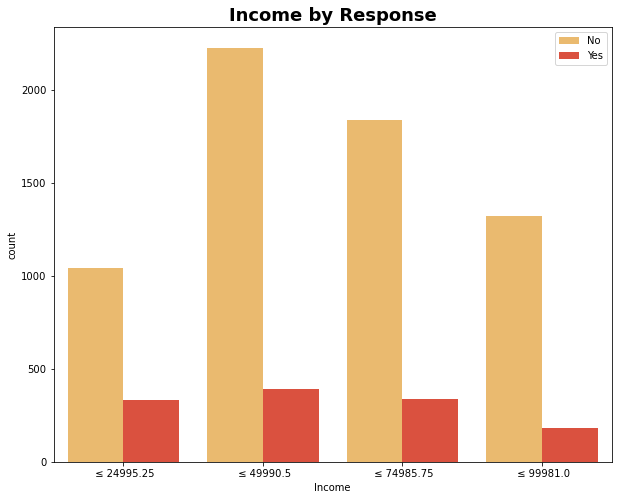

In [36]:
count_plot_w_hue(raw_df, "income", "response")

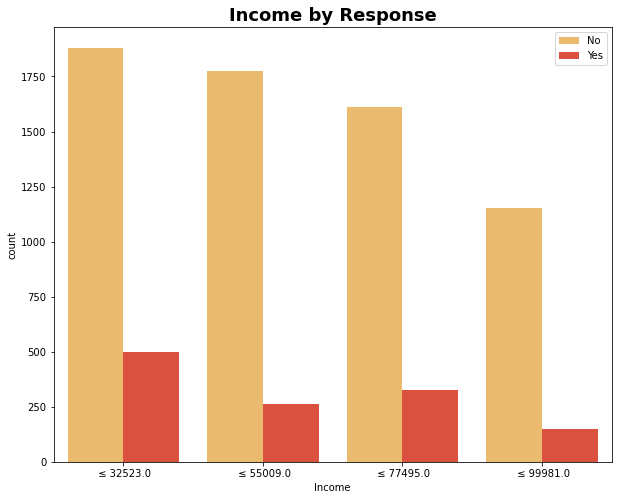

In [37]:
count_plot_w_hue(raw_df[raw_df["income"] > 0], "income", "response")

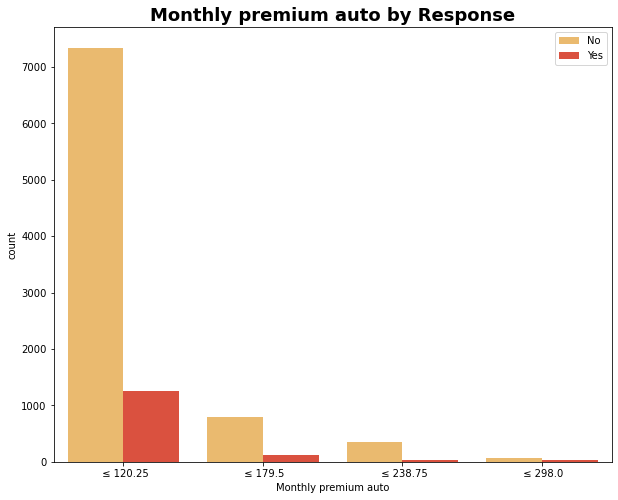

In [38]:
count_plot_w_hue(raw_df, "monthly_premium_auto", "response")

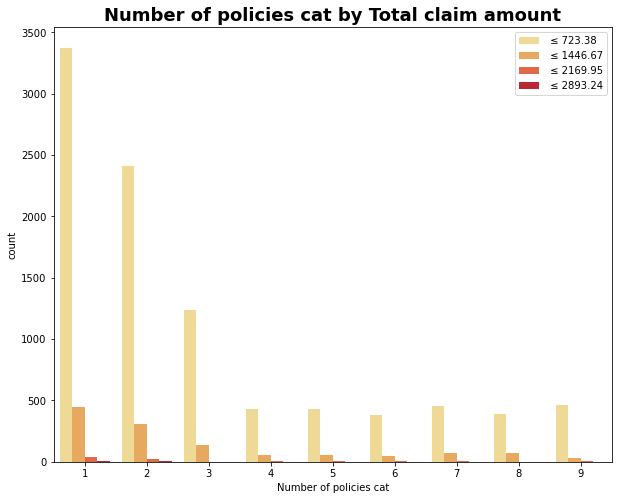

In [39]:
raw_df["number_of_policies_cat"] = raw_df["number_of_policies"].astype('category')
count_plot_w_hue(raw_df, "number_of_policies_cat", "total_claim_amount", x_bins=9)

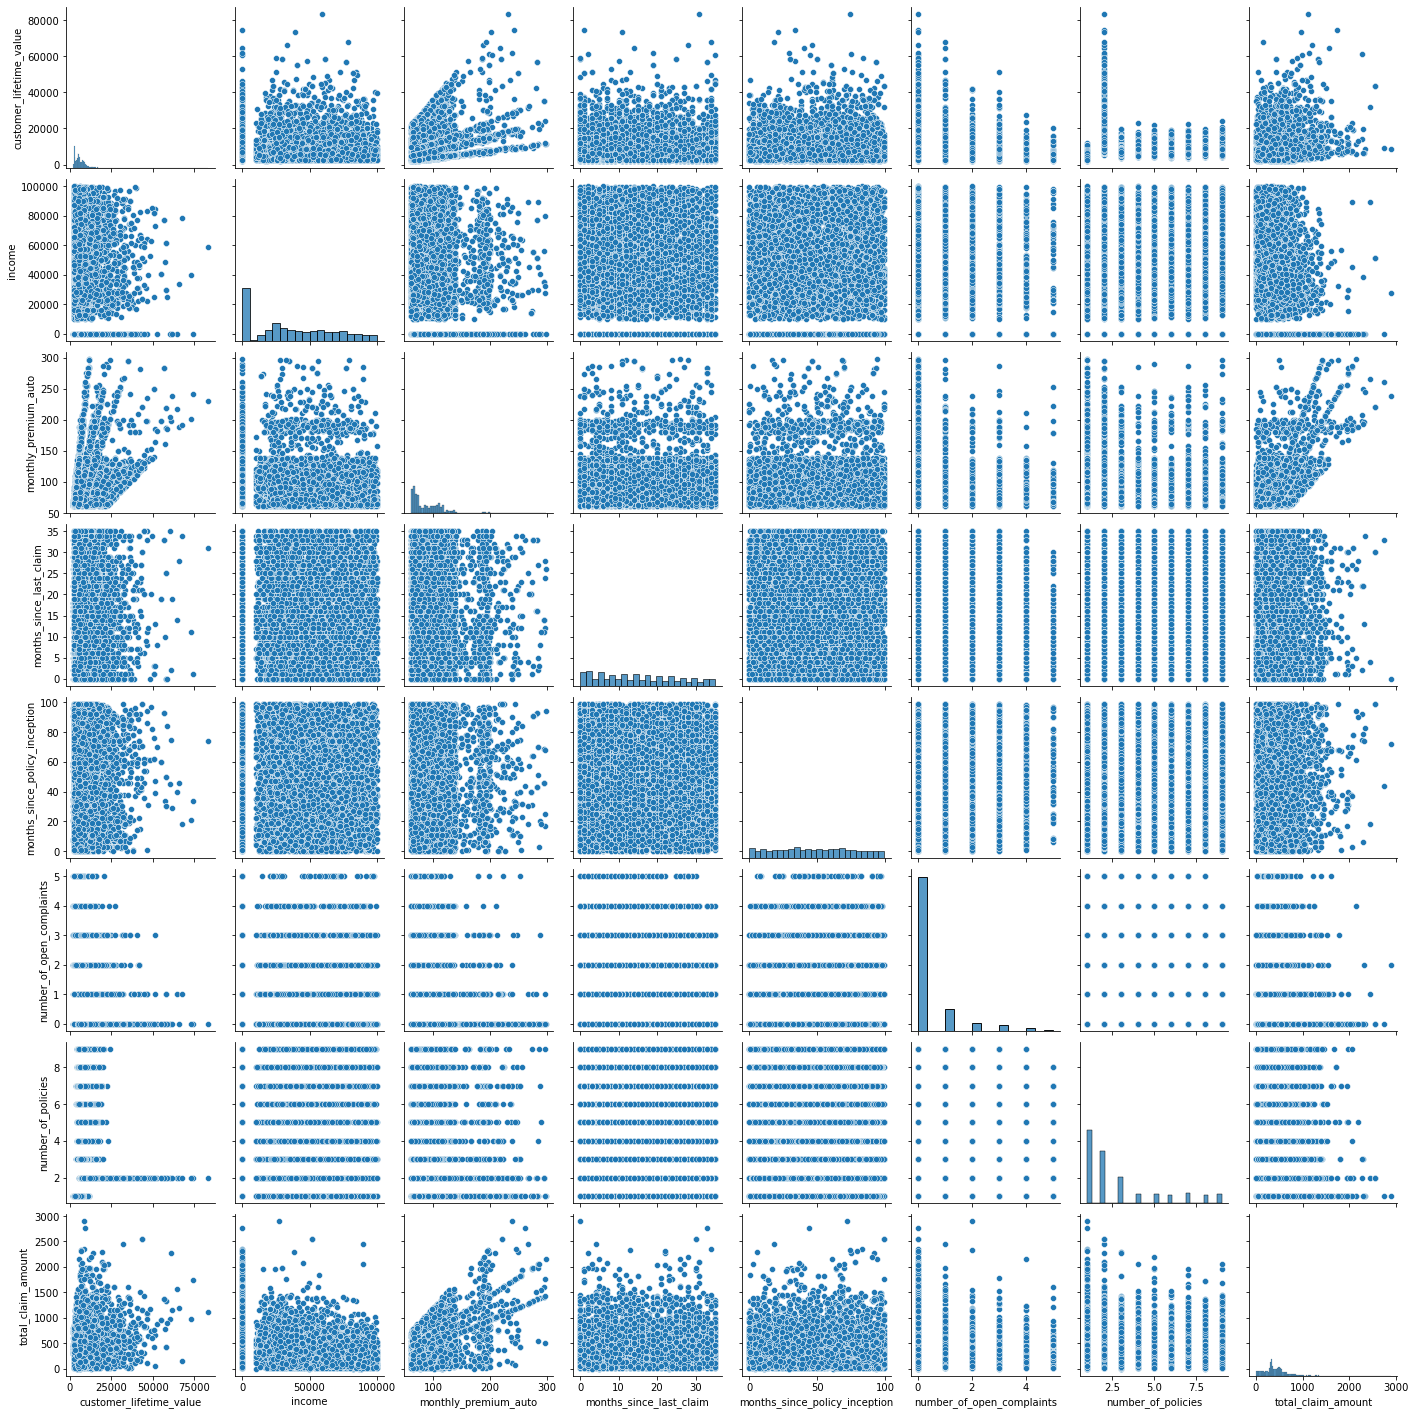

In [40]:
sns.pairplot(split_df_by(raw_df)[0])

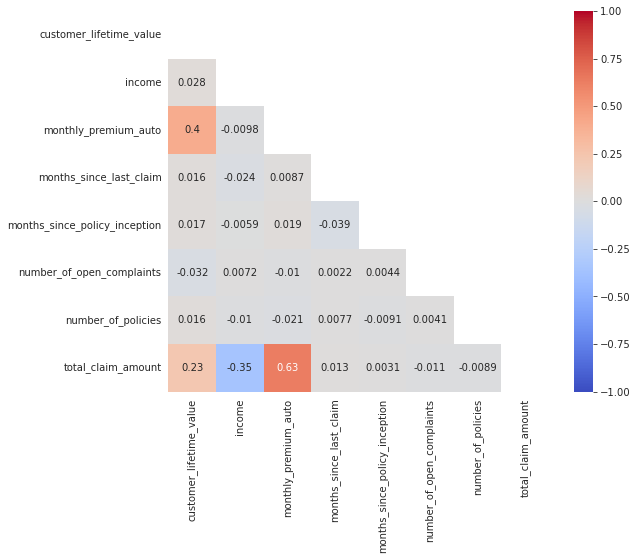

In [41]:
heat_map(raw_df)

In [67]:
(raw_df["Income"])

0        48029
1            0
2        22139
3        49078
4        23675
         ...  
10905        0
10906    61146
10907    39837
10908    64195
10909        0
Name: Income, Length: 10910, dtype: int64

In [69]:
no_zero_inc_df = raw_df
no_zero_inc_df

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2/13/11,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [70]:
no_zero_inc_df = no_zero_inc_df[no_zero_inc_df["Income"] != 0]

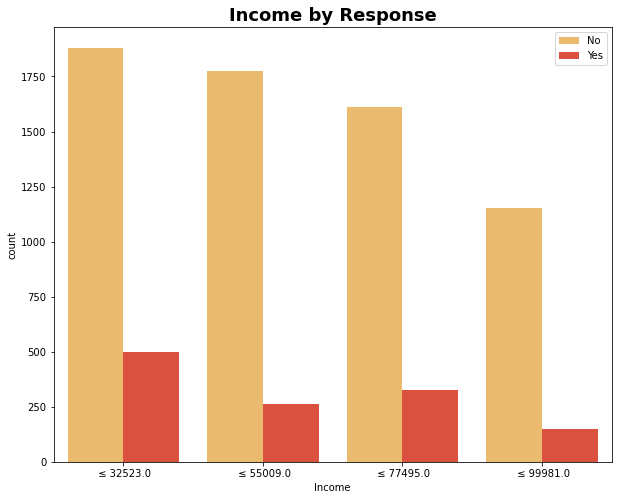

In [84]:
count_plot_w_hue(no_zero_inc_df[no_zero_inc_df["Income"] > 0], "Income", "Response")

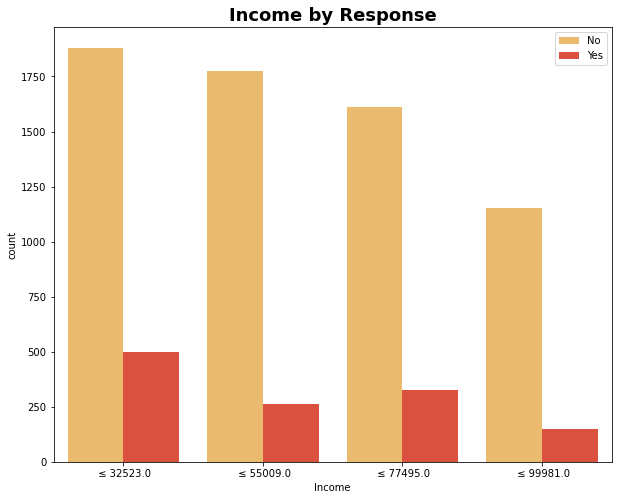

In [82]:
count_plot_w_hue(raw_df[raw_df["Income"] > 0], "Income", "Response")

In [83]:
len(no_zero_inc_df)

8123

In [42]:
################### file1 file2 file3##################

In [43]:
new_df = pd.read_csv("C:/users/roman/documents/tester.csv", index_col=False)

In [44]:
lowercase_underscore_column_names(new_df)
#new_df = new_df.drop("unnamed:_0",axis=1)

In [45]:
new_df["number_of_open_complaints_cat"] = new_df["number_of_open_complaints"].astype("category")

In [46]:
new_nu = split_df_by(new_df)[0]

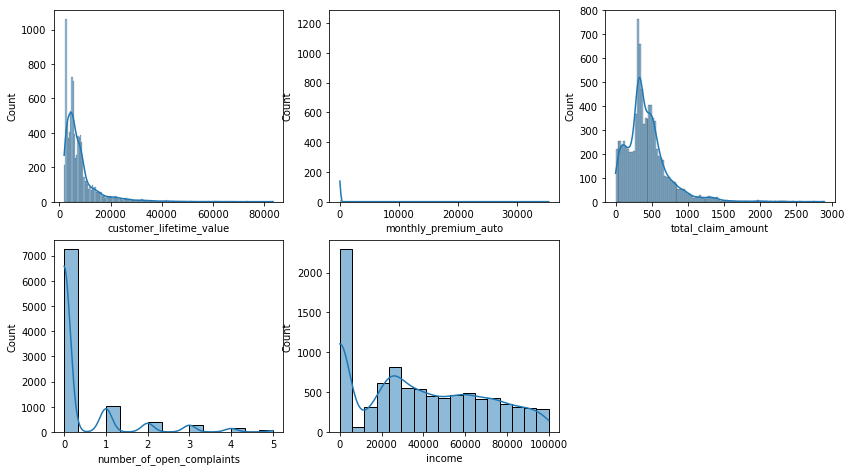

In [47]:
hist_plots(new_nu)

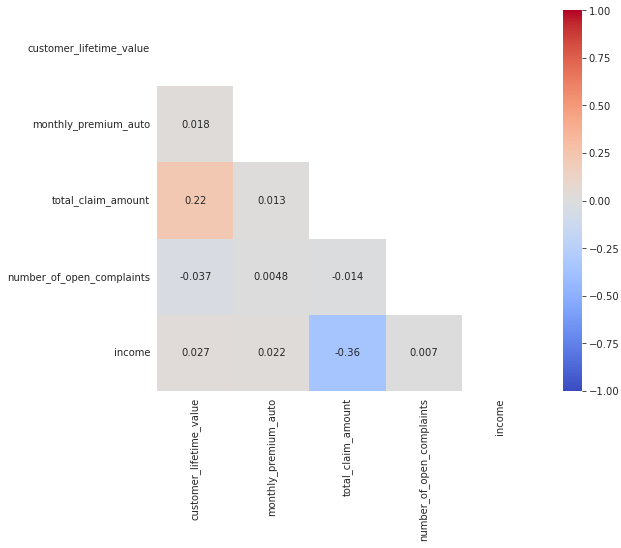

In [48]:
heat_map(new_nu)

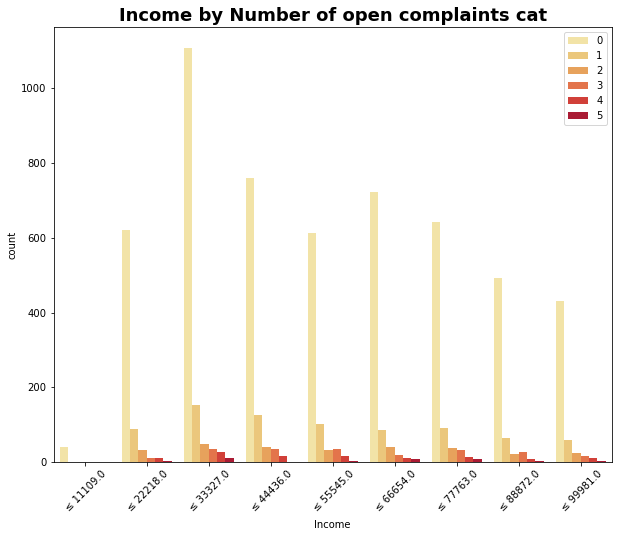

In [49]:
count_plot_w_hue(new_df, "income", "number_of_open_complaints_cat", x_bins=9, rotate_xlabels=45)

In [ ]:
raw_df.to_csv()